In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


In [37]:
data1 = pd.read_csv('../../data/cleaned_data.csv')

In [38]:
data1.head()

,Unnamed: 0,id_var,Quantity,cumsum,cumdist,month,dow,qtr,year,dom,doy,fdom,holiday,ds
0,0,Australia_20685,2.0,2.0,0.0,6,0,2,2010,7,158,1,0,2010-06-07
1,1,Australia_20685,0.0,2.0,1.0,6,1,2,2010,8,159,1,0,2010-06-08
2,2,Australia_20685,0.0,2.0,2.0,6,2,2,2010,9,160,1,0,2010-06-09
3,3,Australia_20685,0.0,2.0,3.0,6,3,2,2010,10,161,1,0,2010-06-10
4,4,Australia_20685,0.0,2.0,4.0,6,4,2,2010,11,162,1,0,2010-06-11


In [39]:
data1.drop(['Unnamed: 0','cumsum','cumdist'],axis=1,inplace=True)

In [40]:
data1['Quantity'].isin([np.inf, -np.inf]).sum()

0

In [41]:
data1['ds'] = pd.to_datetime(data1['ds'])

In [42]:
data1 = data1.loc[data1['year'] > 2009,]

In [43]:
data1['Quantity'].tail()

4018229    0.0
4018230    0.0
4018231    0.0
4018232    0.0
4018233    0.0
Name: Quantity, dtype: float64

In [44]:
# data['Quantity'] = np.log1p(data['Quantity'])

In [45]:
mu = data1.groupby(['id_var'])['Quantity'].mean().reset_index()

In [46]:
mu = mu.rename(columns={'Quantity':'mean'})

In [47]:
std = data1.groupby(['id_var'])['Quantity'].std().reset_index()

In [48]:
std = std.rename(columns={'Quantity':'std'})

In [49]:
data1 = data1.merge(mu,on=['id_var'],how='left')

In [50]:
data1 = data1.merge(std,on=['id_var'],how='left')

In [51]:
data1.head()



,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,ds,mean,std
0,Australia_20685,2.0,6,0,2,2010,7,158,1,0,2010-06-07,0.119923,1.309302
1,Australia_20685,0.0,6,1,2,2010,8,159,1,0,2010-06-08,0.119923,1.309302
2,Australia_20685,0.0,6,2,2,2010,9,160,1,0,2010-06-09,0.119923,1.309302
3,Australia_20685,0.0,6,3,2,2010,10,161,1,0,2010-06-10,0.119923,1.309302
4,Australia_20685,0.0,6,4,2,2010,11,162,1,0,2010-06-11,0.119923,1.309302


In [52]:
data1['wknd'] = np.where((data1['ds']).dt.dayofweek < 5,0,1)

In [53]:
data1['tQuantity'] = (data1['Quantity'] - data1['mean'])/(data1['std'])

In [54]:
data = data1.copy()

In [55]:
data['lag1'] = data.groupby('id_var')['tQuantity'].shift(1)

In [56]:
data['lag7'] = data.groupby('id_var')['tQuantity'].shift(7)

In [57]:
data['lag365'] = data.groupby('id_var')['tQuantity'].shift(365)

In [58]:
data.head()

,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,ds,mean,std,wknd,tQuantity,lag1,lag7,lag365
0,Australia_20685,2.0,6,0,2,2010,7,158,1,0,2010-06-07,0.119923,1.309302,0,1.435938,NaN,NaN,NaN
1,Australia_20685,0.0,6,1,2,2010,8,159,1,0,2010-06-08,0.119923,1.309302,0,-0.091593,1.435938,NaN,NaN
2,Australia_20685,0.0,6,2,2,2010,9,160,1,0,2010-06-09,0.119923,1.309302,0,-0.091593,-0.091593,NaN,NaN
3,Australia_20685,0.0,6,3,2,2010,10,161,1,0,2010-06-10,0.119923,1.309302,0,-0.091593,-0.091593,NaN,NaN
4,Australia_20685,0.0,6,4,2,2010,11,162,1,0,2010-06-11,0.119923,1.309302,0,-0.091593,-0.091593,NaN,NaN


In [59]:
data.dropna(inplace=True)

In [60]:
max_date = pd.to_datetime(data['ds']).max()
mx1_dt = (max_date - pd.to_timedelta(48, unit='d'))

In [61]:
max_date

Timestamp('2011-11-05 00:00:00')

In [62]:
mx1_dt

Timestamp('2011-09-18 00:00:00')

In [63]:
data['ds'] = pd.to_datetime(data['ds'])
train = data.loc[data['ds'] <= mx1_dt,]

In [64]:
val = data.loc[data['ds'] > mx1_dt,]
val_f = val[[x for x in val.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
val_f.index = val['ds']
val_f = val_f.drop(['ds'],axis=1)

In [65]:
train_f = train[[x for x in train.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
train_f.index = train.ds
train_f = train_f.drop(['ds'],axis=1)

In [66]:
mx_dt = (train['ds'].max() - pd.to_timedelta(28, unit='d'))

In [67]:
mx_dt

Timestamp('2011-08-21 00:00:00')

In [68]:
train1 = train.loc[train['ds'] <= mx_dt,]
train1.index = train1['ds']
train1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [69]:
val1 = train.loc[train['ds'] >  mx_dt,]

In [70]:
val1.index = val1['ds']
val1.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [71]:
val1.index.max()

Timestamp('2011-09-18 00:00:00')

In [72]:
test = data.loc[data['ds'] > val1.index.max(),]
test.index = test['ds']
test.drop(['ds'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [73]:
test['tQuantity'].isin([np.inf,-np.inf]).sum()

0

In [74]:
train_x = train1[[x for x in train1.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
train_y = train1['tQuantity']


In [75]:
! pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [76]:
import category_encoders as ce
id_encoder =  ce.OrdinalEncoder()
id_encoder.fit(train_x['id_var'])
train_x['id_cat'] = id_encoder.transform(train_x['id_var'])
train_x1 = train_x.drop(['id_var'],axis=1)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [77]:
val_x = val1[[x for x in val1.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
val_y = val1['tQuantity']

In [78]:
val_x['id_cat'] = id_encoder.transform(val_x['id_var'])
val_x1 = val_x.drop(['id_var'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
test_x = test[[x for x in test.columns if x not in ['tQuantity','Quantity','mean','qtr']]]
test_x['id_cat'] = id_encoder.transform(test_x['id_var'])
test_x1 = test_x.drop(['id_var'],axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
train_f['id_cat'] = id_encoder.transform(train_f['id_var'])
train_f = train_f.drop(['id_var'],axis=1)

In [81]:
train_fy = train['tQuantity']

In [82]:
val_f['id_cat'] = id_encoder.transform(val_f['id_var'])
val_f.drop(['id_var'],axis=1,inplace=True)
val_fy = val['tQuantity']

In [83]:
! pip install optuna

     |████████████████████████████████| 296kB 5.3MB/s 
     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 1.1MB 6.2MB/s 
     |████████████████████████████████| 143kB 22.2MB/s 
     |████████████████████████████████| 112kB 23.5MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 481kB 17.1MB/s 
  Created wheel for alembic: filename=alembic-1.5.4-py2.py3-none-any.whl size=156314 sha256=bc65c20bb08edbc4519bcec58de79bbc5875314cc01783ee1763636a604735ed
  Stored in directory: /root/.cache/pip/wheels/fd/2d/ec/5a1b1e2363ed68392d292d215facf588d5448198edd8078bc1
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=ca0470b48c2627727daa7ddfc945378a5db84837dcdf23efade02fb3c602433d
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha256=7

In [84]:
import optuna
import optuna.integration.lightgbm as lgb
from optuna.integration.lightgbm import LightGBMTuner

In [85]:
# params = {
#     'objective': 'tweedie',
#     'boosting_type':'goss',
#     "eval_metric":'mse',
#     'metric':'mse'
# }

In [86]:
train_x1.columns.tolist()

['month',
 'dow',
 'year',
 'dom',
 'doy',
 'fdom',
 'holiday',
 'std',
 'wknd',
 'lag1',
 'lag7',
 'lag365',
 'id_cat']

In [87]:
categorical_feature = ['month','dow','wknd','dom','doy','fdom','holiday','id_cat']

In [88]:
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [89]:
# tuned_model = LightGBMTuner(params, train_set=lgb_train,
#                                      valid_sets=lgb_valid,
#                                      num_boost_round=1000,
#                                      early_stopping_rounds=100,
#                                     )

In [90]:
# tuned_model.run()

In [91]:
# best_params = tuned_model.best_params

In [92]:
best_params = {'bagging_fraction': 0.80,
 'bagging_freq': 4,
 'boosting_type': 'gbdt',
 'eval_metric': 'mape',
 'feature_fraction': 0.4,
 'feature_pre_filter': False,
#  'lambda_l1': 0.46302449182034366,
 'lambda_l2': 0.005966885023281192,
 'metric': 'l1',
 'tweedie_variance_power':1.2,
 'min_child_samples': 20,
 'num_leaves': 31,
 'objective': 'regression'}


In [93]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train_x1,train_y,categorical_feature=categorical_feature)
lgb_valid = lgb.Dataset(val_x1, val_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_x1,reference=lgb_train)

In [94]:
model = lgb.train(best_params,lgb_train, valid_sets=lgb_valid,num_boost_round=1000,early_stopping_rounds=30)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['dom', 'dow', 'doy', 'fdom', 'holiday', 'id_cat', 'month', 'wknd']

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



[1]	valid_0's l1: 0.236589
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l1: 0.226221
[3]	valid_0's l1: 0.217198
[4]	valid_0's l1: 0.216665
[5]	valid_0's l1: 0.209196
[6]	valid_0's l1: 0.203288
[7]	valid_0's l1: 0.202894
[8]	valid_0's l1: 0.202702
[9]	valid_0's l1: 0.202414
[10]	valid_0's l1: 0.201315
[11]	valid_0's l1: 0.200941
[12]	valid_0's l1: 0.197001
[13]	valid_0's l1: 0.192864
[14]	valid_0's l1: 0.192946
[15]	valid_0's l1: 0.192472
[16]	valid_0's l1: 0.192314
[17]	valid_0's l1: 0.18841
[18]	valid_0's l1: 0.188385
[19]	valid_0's l1: 0.188557
[20]	valid_0's l1: 0.185432
[21]	valid_0's l1: 0.185539
[22]	valid_0's l1: 0.185577
[23]	valid_0's l1: 0.183397
[24]	valid_0's l1: 0.183718
[25]	valid_0's l1: 0.183484
[26]	valid_0's l1: 0.183758
[27]	valid_0's l1: 0.183659
[28]	valid_0's l1: 0.181206
[29]	valid_0's l1: 0.181314
[30]	valid_0's l1: 0.179723
[31]	valid_0's l1: 0.177741
[32]	valid_0's l1: 0.177665
[33]	valid_0's l1: 0.178119
[34]	valid_0's l1: 0.176

In [95]:
import seaborn as sns


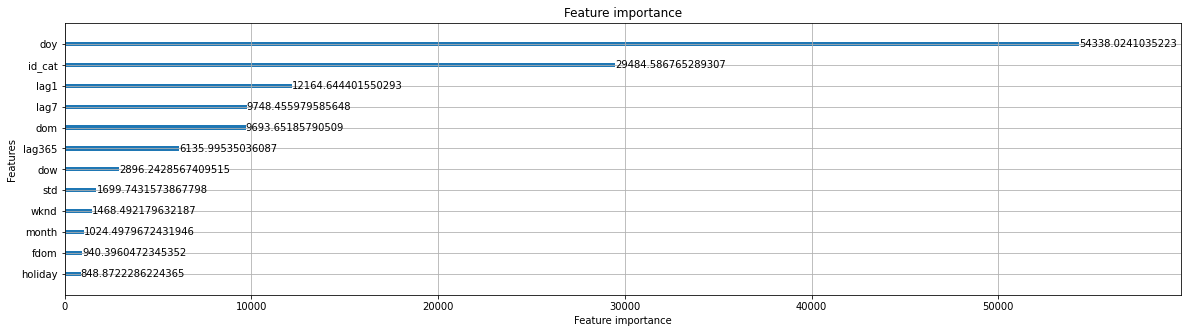

In [ ]:
lgb.plot_importance(model,importance_type='gain',figsize=(20,5))

In [ ]:
val_x1.head()

,month,dow,year,dom,doy,fdom,holiday,std,wknd,lag1,lag7,lag365,id_cat
ds,,,,,,,,,,,,,
2011-08-22,8,0,2011,22,234,3,0,1.309302,0,-0.091593,-0.091593,-0.091593,1.0
2011-08-23,8,1,2011,23,235,3,0,1.309302,0,-0.091593,-0.091593,-0.091593,1.0
2011-08-24,8,2,2011,24,236,3,0,1.309302,0,-0.091593,-0.091593,-0.091593,1.0
2011-08-25,8,3,2011,25,237,3,0,1.309302,0,-0.091593,-0.091593,-0.091593,1.0
2011-08-26,8,4,2011,26,238,3,0,1.309302,0,-0.091593,-0.091593,-0.091593,1.0


In [ ]:
val1['forecast'] = model.predict(val_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train1['forecast'] = model.predict(train_x1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
train_val = pd.concat([train1,val1],axis=0)

In [ ]:
vale = train_val.copy()
vale.head()

,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,mean,std,wknd,tQuantity,lag1,lag7,lag365,forecast
ds,,,,,,,,,,,,,,,,,,
2011-06-07,Australia_20685,0.0,6,1,2,2011,7,158,1,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,1.435938,-0.004226
2011-06-08,Australia_20685,0.0,6,2,2,2011,8,159,1,0,0.119923,1.309302,0,-0.091593,-0.091593,15.183717,-0.091593,-0.173566
2011-06-09,Australia_20685,0.0,6,3,2,2011,9,160,1,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,0.029075
2011-06-10,Australia_20685,0.0,6,4,2,2011,10,161,1,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,0.138612
2011-06-11,Australia_20685,0.0,6,5,2,2011,11,162,1,0,0.119923,1.309302,1,-0.091593,-0.091593,-0.091593,-0.091593,-0.115401


In [ ]:
vale['forecast'].max()

1.6044913367673836

In [ ]:
for lag in range(2,7):
  vale['lag'+str(lag)] = vale.groupby(['id_var'])['tQuantity'].shift(lag)


In [ ]:
data

,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,ds,mean,std,wknd,tQuantity,lag1,lag7,lag365
365,Australia_20685,0.0,6,1,2,2011,7,158,1,0,2011-06-07,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,1.435938
366,Australia_20685,0.0,6,2,2,2011,8,159,1,0,2011-06-08,0.119923,1.309302,0,-0.091593,-0.091593,15.183717,-0.091593
367,Australia_20685,0.0,6,3,2,2011,9,160,1,0,2011-06-09,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593
368,Australia_20685,0.0,6,4,2,2011,10,161,1,0,2011-06-10,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593
369,Australia_20685,0.0,6,5,2,2011,11,162,1,0,2011-06-11,0.119923,1.309302,1,-0.091593,-0.091593,-0.091593,-0.091593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287318,United Kingdom_gift_0001_50,0.0,11,1,4,2011,1,305,0,-1,2011-11-01,0.026706,0.410702,0,-0.065026,-0.065026,-0.065026,-0.065026
3287319,United Kingdom_gift_0001_50,0.0,11,2,4,2011,2,306,0,-1,2011-11-02,0.026706,0.410702,0,-0.065026,-0.065026,-0.065026,-0.065026
3287320,United Kingdom_gift_0001_50,0.0,11,3,4,2011,3,307,0,-1,2011-11-03,0.026706,0.410702,0,-0.065026,-0.065026,-0.065026,-0.065026
3287321,United Kingdom_gift_0001_50,0.0,11,4,4,2011,4,308,0,-1,2011-11-04,0.026706,0.410702,0,-0.065026,-0.065026,-0.065026,-0.065026


In [ ]:
data1.tail()

,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,ds,mean,std,wknd,tQuantity
3287318,United Kingdom_gift_0001_50,0.0,11,1,4,2011,1,305,0,-1,2011-11-01,0.026706,0.410702,0,-0.065026
3287319,United Kingdom_gift_0001_50,0.0,11,2,4,2011,2,306,0,-1,2011-11-02,0.026706,0.410702,0,-0.065026
3287320,United Kingdom_gift_0001_50,0.0,11,3,4,2011,3,307,0,-1,2011-11-03,0.026706,0.410702,0,-0.065026
3287321,United Kingdom_gift_0001_50,0.0,11,4,4,2011,4,308,0,-1,2011-11-04,0.026706,0.410702,0,-0.065026
3287322,United Kingdom_gift_0001_50,0.0,11,5,4,2011,5,309,0,-1,2011-11-05,0.026706,0.410702,1,-0.065026


In [ ]:
col = [x for x in vale.columns if x != 'id_var']

In [ ]:
c = vale.groupby(['id_var'])[col+['id_var']].tail(1).reset_index()

In [ ]:
c = c.loc[c['Quantity']!=0]

In [ ]:
# c.merge(data,on=['id_var','ds'],how='left')

In [ ]:
id_encoder.transform(vale['id_var'].head(1))

,id_var
ds,
2011-06-07,1


In [ ]:
val1.loc[val1['Quantity'] >0,'forecast'].max()

0.47475411713486576

In [ ]:
val_x.columns.tolist()

['id_var',
 'month',
 'dow',
 'year',
 'dom',
 'doy',
 'fdom',
 'holiday',
 'std',
 'wknd',
 'lag1',
 'lag7',
 'lag365',
 'id_cat']

In [ ]:
da= pd.DataFrame(columns=['id','var'])

In [ ]:
val_x1.columns

Index(['month', 'dow', 'year', 'dom', 'doy', 'fdom', 'holiday', 'std', 'wknd',
       'lag1', 'lag7', 'lag365', 'id_cat'],
      dtype='object')

In [ ]:
colname = train_val.columns

In [ ]:
train_val.groupby(['id_var'])[colname].tail(1).reset_index()

,ds,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,mean,std,wknd,tQuantity,lag1,lag7,lag365,forecast
0,2011-09-18,Australia_20685,0.0,9,6,3,2011,18,261,2,0,0.119923,1.309302,1,-0.091593,-0.091593,-0.091593,-0.091593,-0.038954
1,2011-09-18,Australia_20725,0.0,9,6,3,2011,18,261,2,0,0.359788,4.397371,1,-0.081819,-0.081819,-0.081819,-0.081819,0.047883
2,2011-09-18,Australia_20726,0.0,9,6,3,2011,18,261,2,0,0.634921,7.104269,1,-0.089372,-0.089372,-0.089372,-0.089372,0.040579
3,2011-09-18,Australia_20727,0.0,9,6,3,2011,18,261,2,0,0.267062,4.143046,1,-0.064460,-0.064460,-0.064460,-0.064460,0.001708
4,2011-09-18,Australia_21731,0.0,9,6,3,2011,18,261,2,0,2.123711,21.977265,1,-0.096632,-0.096632,-0.096632,-0.096632,0.037697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701,2011-09-18,United Kingdom_POST,0.0,9,6,3,2011,18,261,2,-1,3.728487,42.159575,1,-0.088437,-0.088437,-0.088437,-0.088437,-0.003668
4702,2011-09-18,United Kingdom_gift_0001_10,0.0,9,6,3,2011,18,261,2,-1,0.054154,0.722462,1,-0.074958,-0.074958,-0.074958,-0.074958,-0.030995
4703,2011-09-18,United Kingdom_gift_0001_20,0.0,9,6,3,2011,18,261,2,-1,0.071217,0.605303,1,-0.117654,-0.117654,-0.117654,-0.117654,-0.038508
4704,2011-09-18,United Kingdom_gift_0001_30,0.0,9,6,3,2011,18,261,2,-1,0.082344,0.764829,1,-0.107664,-0.107664,-0.107664,-0.107664,-0.046690


In [ ]:
data1.loc[data1['ds']=='2011-09-18',]

,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,ds,mean,std,wknd,tQuantity
468,Australia_20685,0.0,9,6,3,2011,18,261,2,0,2011-09-18,0.119923,1.309302,1,-0.091593
1098,Australia_20725,0.0,9,6,3,2011,18,261,2,0,2011-09-18,0.359788,4.397371,1,-0.081819
1728,Australia_20726,0.0,9,6,3,2011,18,261,2,0,2011-09-18,0.634921,7.104269,1,-0.089372
2402,Australia_20727,0.0,9,6,3,2011,18,261,2,0,2011-09-18,0.267062,4.143046,1,-0.064460
2984,Australia_21731,0.0,9,6,3,2011,18,261,2,0,2011-09-18,2.123711,21.977265,1,-0.096632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3284578,United Kingdom_POST,0.0,9,6,3,2011,18,261,2,-1,2011-09-18,3.728487,42.159575,1,-0.088437
3285252,United Kingdom_gift_0001_10,0.0,9,6,3,2011,18,261,2,-1,2011-09-18,0.054154,0.722462,1,-0.074958
3285926,United Kingdom_gift_0001_20,0.0,9,6,3,2011,18,261,2,-1,2011-09-18,0.071217,0.605303,1,-0.117654
3286600,United Kingdom_gift_0001_30,0.0,9,6,3,2011,18,261,2,-1,2011-09-18,0.082344,0.764829,1,-0.107664


In [ ]:
# train_val['ds'].unique()

In [ ]:
def recursive_forecast(val,data,model,id_encoder,forecast_range=48,var='Quantity'):
  dat = val.copy()
  dat1 =data.copy().reset_index()
  colname= dat.columns.tolist()
  for lag in range(2,7):
    dat['lag'+str(lag)] = dat.groupby(['id_var'])[var].shift(lag)
  
  dat = dat.groupby(['id_var'])[colname].tail(1).reset_index()
  # dat['lag_365'] = 1
  # print(dat.head())
  da = dat.copy()
  
  print(da['ds'].unique())
  da_f = pd.DataFrame()  
  for fr in range(1,forecast_range):
    
    da['ds'] = da['ds'] + pd.DateOffset(days=1)
    if fr < 7:
      for i in range(1,7):
        if i == 1:
          da['lag'+str(i)] = dat['forecast'].values
                   
        else:
          da['lag'+str(i+1)] = dat['lag'+str(i)].values
          # print(da.head())
        if i == 6:
          datt = da['ds']-pd.to_timedelta(365, unit='d')
          print(datt,'\n',da['ds'])
          dat12 = dat1.loc[dat1['ds'].isin(datt),['id_var','ds']+[var]]
          dat12 = dat12.rename(columns={var:'lag365'})
          da['ds365'] = da['ds'] -pd.to_timedelta(365, unit='d')
          da11 = da[['ds365','id_var']].merge(dat12[['id_var','ds','lag365']],left_on=['id_var','ds365'],right_on=['id_var','ds'],how='left')
          print(da11)

          da['lag365'] = da11['lag365']
          # print(da)
          # print(da['lag365'])
          da['id_cat'] = id_encoder.transform(da['id_var'])
          
          da1 = da[['month', 'dow', 'year', 'dom', 'doy', 'fdom', 'holiday', 'std', 'wknd',
                    'lag1', 'lag7','lag365','id_cat']]
          # print(da1)
          # print(da1.head())
          da.loc[:,'forecast'] = model.predict(da1)
      da_f = pd.concat([da_f,da],axis=0)
    
    else:
      for j in range(1,7):
        if j == 1 :
          da['lag'+str(j)] = da['forecast']
          
        elif j < 7:
          # print(da['lag'+str(j+1)])
          da['lag'+str(j+1)] = da['lag'+str(j)]
        if j == 6:
          datt = da['ds']-pd.to_timedelta(365, unit='d')
          # print(datt,'\n',da['ds'])
          dat12 = dat1.loc[dat1['ds'].isin(datt),['id_var','ds']+[var]]
          dat12 = dat12.rename(columns={var:'lag365'})
          da['ds365'] = da['ds'] -pd.to_timedelta(365, unit='d')
          da11 = da[['ds365','id_var']].merge(dat12[['id_var','ds','lag365']],left_on=['id_var','ds365'],right_on=['id_var','ds'],how='left')
          # da11 = da11.rename(columns={})
          print(da11)
          da['lag365'] = da11['lag365']
          # print(da)
          # print(da['lag365'])
          da['id_cat'] = id_encoder.transform(da['id_var'])
          da1 = da[['month', 'dow', 'year', 'dom', 'doy', 'fdom', 'holiday', 'std', 'wknd',
                    'lag1', 'lag7','lag365','id_cat']]
          # print(da1)
          # print(da1.head())
          da.loc[:,'forecast'] = model.predict(da1)
      da_f = pd.concat([da_f,da],axis=0)
  return da_f
 

In [ ]:
fr = recursive_forecast(vale,data1,model,id_encoder,48,'tQuantity')

['2011-09-18T00:00:00.000000000']
0      2010-09-19
1      2010-09-19
2      2010-09-19
3      2010-09-19
4      2010-09-19
          ...    
4701   2010-09-19
4702   2010-09-19
4703   2010-09-19
4704   2010-09-19
4705   2010-09-19
Name: ds, Length: 4706, dtype: datetime64[ns] 
 0      2011-09-19
1      2011-09-19
2      2011-09-19
3      2011-09-19
4      2011-09-19
          ...    
4701   2011-09-19
4702   2011-09-19
4703   2011-09-19
4704   2011-09-19
4705   2011-09-19
Name: ds, Length: 4706, dtype: datetime64[ns]
          ds365                       id_var         ds    lag365
0    2010-09-19              Australia_20685 2010-09-19 -0.091593
1    2010-09-19              Australia_20725 2010-09-19 -0.081819
2    2010-09-19              Australia_20726 2010-09-19 -0.089372
3    2010-09-19              Australia_20727 2010-09-19 -0.064460
4    2010-09-19              Australia_21731 2010-09-19 -0.096632
...         ...                          ...        ...       ...
4701 2010-09-1

In [ ]:
fr.head()

,ds,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,mean,std,wknd,tQuantity,lag1,lag7,lag365,forecast,lag2,lag3,lag4,lag5,lag6,ds365,id_cat
0,2011-09-19,Australia_20685,0.0,9,6,3,2011,18,261,2,0,0.119923,1.309302,1,-0.091593,-0.038954,-0.091593,-0.091593,-0.004695,-0.091593,-0.091593,-0.091593,-0.091593,-0.091593,2010-09-19,1.0
1,2011-09-19,Australia_20725,0.0,9,6,3,2011,18,261,2,0,0.359788,4.397371,1,-0.081819,0.047883,-0.081819,-0.081819,0.066602,-0.081819,-0.081819,-0.081819,-0.081819,-0.081819,2010-09-19,2.0
2,2011-09-19,Australia_20726,0.0,9,6,3,2011,18,261,2,0,0.634921,7.104269,1,-0.089372,0.040579,-0.089372,-0.089372,0.059298,-0.089372,-0.089372,-0.089372,-0.089372,-0.089372,2010-09-19,3.0
3,2011-09-19,Australia_20727,0.0,9,6,3,2011,18,261,2,0,0.267062,4.143046,1,-0.064460,0.001708,-0.064460,-0.064460,0.026791,-0.064460,-0.064460,-0.064460,-0.064460,-0.064460,2010-09-19,4.0
4,2011-09-19,Australia_21731,0.0,9,6,3,2011,18,261,2,0,2.123711,21.977265,1,-0.096632,0.037697,-0.096632,-0.096632,0.071955,-0.096632,-0.096632,-0.096632,-0.096632,-0.096632,2010-09-19,5.0


In [ ]:
data.loc[data['ds'] == '2010-08-19',]

,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,ds,mean,std,wknd,tQuantity,lag1,lag7,lag365


In [ ]:
data['ds'].min()

Timestamp('2011-01-01 00:00:00')

In [ ]:
test = test.reset_index()

In [ ]:
test.head()

,ds,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,mean,std,wknd,tQuantity,lag1,lag7,lag365
0,2011-09-19,Australia_20685,0.0,9,0,3,2011,19,262,2,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593
1,2011-09-20,Australia_20685,0.0,9,1,3,2011,20,263,2,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593
2,2011-09-21,Australia_20685,0.0,9,2,3,2011,21,264,3,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593
3,2011-09-22,Australia_20685,0.0,9,3,3,2011,22,265,3,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593
4,2011-09-23,Australia_20685,0.0,9,4,3,2011,23,266,3,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593


In [ ]:
# test.drop(['forecast_x','forecast_y'],axis=1,inplace=True)

In [ ]:
test1 = test.merge(fr[['id_var','ds','forecast']],on=['id_var','ds'],how='left')

In [ ]:
test1.head()

,ds,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,mean,std,wknd,tQuantity,lag1,lag7,lag365,forecast
0,2011-09-19,Australia_20685,0.0,9,0,3,2011,19,262,2,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,-0.004695
1,2011-09-20,Australia_20685,0.0,9,1,3,2011,20,263,2,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,-0.004695
2,2011-09-21,Australia_20685,0.0,9,2,3,2011,21,264,3,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,-0.004695
3,2011-09-22,Australia_20685,0.0,9,3,3,2011,22,265,3,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,-0.004695
4,2011-09-23,Australia_20685,0.0,9,4,3,2011,23,266,3,0,0.119923,1.309302,0,-0.091593,-0.091593,-0.091593,-0.091593,-0.004695


In [ ]:
test1['forecast'] = test1['forecast']*test1['std'] + test1['mean']

In [ ]:
# test1['Quantity'] = test1['Quantity'].apply(np.expm1)
# test1['forecast'] = test1['forecast'].apply(np.expm1)

In [ ]:
# test1['forecast'] = np.floor(test1['forecast'])

In [ ]:
test1['error'] = np.abs(test1['Quantity']-test1['forecast'])/(test1['Quantity']+1)

In [ ]:
test1.groupby('id_var')['error'].mean().mean()

1.004010379369327

In [ ]:
test1.loc[test['Quantity'] != 0, 'forecast'].max()

73.99293830032718

In [ ]:
country_stock = test['id_var'].str.split('_',n=1,expand=True)

In [ ]:
country_stock_dist = test['id_var'].str.split('_',n=1,expand=True)

In [ ]:
len(country_stock_dist[1])

226988

In [ ]:
test1['Country'] = country_stock[0]
test1['Stock_Code'] = country_stock[1]

In [ ]:
test1['week_start'] = test1['ds'].dt.to_period('W-Sun').dt.to_timestamp()

In [ ]:
test_week = test1.groupby(['Stock_Code','week_start'])['Quantity','forecast'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
test_week['error'] = np.abs(test_week['Quantity']-test_week['forecast'])/(test_week['Quantity']+1)

In [ ]:
testq = test.loc[test['Quantity'] != 0, ]

In [ ]:
testq.tail()

,ds,id_var,Quantity,month,dow,qtr,year,dom,doy,fdom,holiday,mean,std,wknd,tQuantity,lag1,lag7,lag365
226790,2011-10-31,United Kingdom_POST,1.000000,10,0,4,2011,31,304,4,-1,3.728487,42.159575,0,-0.064718,-0.088437,-0.088437,-0.088437
226791,2011-11-01,United Kingdom_POST,332.666667,11,1,4,2011,1,305,0,-1,3.728487,42.159575,0,7.802218,-0.064718,-0.064718,-0.088437
226794,2011-11-04,United Kingdom_POST,1.000000,11,4,4,2011,4,308,0,-1,3.728487,42.159575,0,-0.064718,-0.088437,-0.088437,-0.088437
226886,2011-10-31,United Kingdom_gift_0001_20,1.000000,10,0,4,2011,31,304,4,-1,0.071217,0.605303,0,1.534411,-0.117654,-0.117654,-0.117654
226911,2011-10-08,United Kingdom_gift_0001_30,1.000000,10,5,4,2011,8,281,1,-1,0.082344,0.764829,1,1.199819,-0.107664,-0.107664,-0.107664


In [ ]:
terror = test_week.groupby(['Stock_Code'])['error'].mean().reset_index()

In [ ]:
terror = terror.sort_values(by='error',ascending=False)

In [ ]:
terror.mean()

error    3.080047
dtype: float64

In [ ]:
top_cont = terror.loc[terror['Stock_Code'].isin(country_stock_dist[1]),]

In [ ]:
test_week.to_csv('../../data/test_lgb.csv')

In [ ]:
te = top_cont.loc[top_cont['error'] < .5,]

In [ ]:
len(te['Stock_Code'].unique())

526

In [ ]:
tw = test_week.loc[test1['Stock_Code'].isin(te['Stock_Code'].unique()),]


In [ ]:
tw.index= tw['week_start']

In [ ]:
tw.drop(['week_start'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
tw.groupby(['Stock_Code'])[['Quantity','forecast']].plot()

Output hidden; open in https://colab.research.google.com to view.

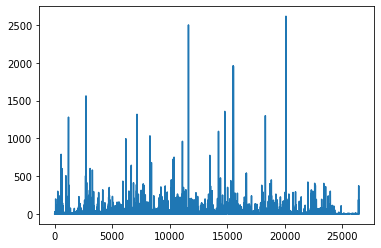

In [ ]:
test_week['Quantity'].plot()

In [ ]:
! pip install optuna